# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.331376,True,5.914611
1,1.199270,True,5.913096
2,1.206445,True,6.852123
3,-0.931437,False,-2.010041
4,-1.560628,False,-1.792360
...,...,...,...
995,1.259893,True,6.894041
996,0.486704,True,4.925201
997,1.554382,True,5.708392
998,-1.207521,False,-0.206661


<Axes: xlabel='v0'>

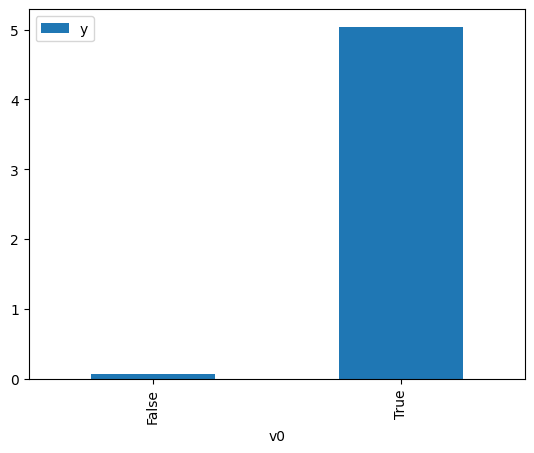

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

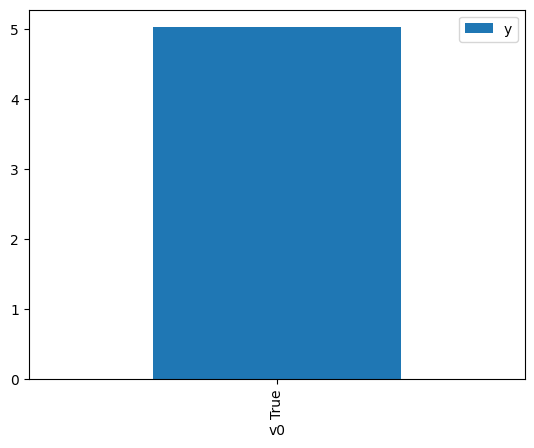

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.497595,False,-0.058262,0.737477,1.355974
1,1.173374,False,0.358622,0.128909,7.757432
2,-0.252260,False,0.520030,0.645821,1.548416
3,-1.669241,False,-2.358127,0.956762,1.045192
4,0.405340,False,0.206643,0.364082,2.746637
...,...,...,...,...,...
995,0.058729,False,-0.111993,0.513219,1.948484
996,0.658112,False,1.375983,0.268358,3.726366
997,1.648415,False,2.144599,0.060230,16.603014
998,-0.560071,False,-1.705115,0.758222,1.318876


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.012943,True,4.366690,0.125568,7.963786
1,-1.726998,True,4.406920,0.039219,25.497858
2,-0.414041,True,3.869247,0.291996,3.424706
3,0.812864,True,4.887818,0.781696,1.279270
4,-0.071962,True,2.932027,0.429691,2.327254
...,...,...,...,...,...
995,-0.197215,True,4.659854,0.376659,2.654924
996,-0.408244,True,2.604110,0.294111,3.400073
997,0.256428,True,4.085659,0.573311,1.744254
998,0.838036,True,5.191954,0.789168,1.267157


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              8174.
Date:                Mon, 06 Nov 2023   Prob (F-statistic):                        0.00
Time:                        17:35:45   Log-Likelihood:                         -1407.9
No. Observations:                1000   AIC:                                      2820.
Df Residuals:                     998   BIC:                                      2830.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8843      0.036     24.418      0.000       0.813       0.955
x2             4.9582      0.050     99.124      0.000       4.860       5.056
==============================================================================
Omnibus:                        0.906   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.636   Jarque-Bera (JB):                0.774
Skew:                           0.036   Prob(JB):                        0.679
Kurtosis:                       3.116   Cond. No.                         1.85
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""